In [3]:
"""
Calculate the damage of a combo.
"""
import sys
import math
import pandas as pd
from constants import *  # NOSONAR
import parseCombo
import os
import tabulate
import matplotlib.pyplot as plt

plt.close("all")

# Find the data directory, should be one level up from the python directory
data_dir: str = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data"))

move_name_alias_df: pd.DataFrame = pd.read_csv(f"{data_dir}\\moveNameAliases.csv")
full_framedata_df: pd.DataFrame = pd.read_csv(f"{data_dir}\\fullFrameData.csv")

# Remove any whitespace from column names in the full_framedata_df and move_name_alias_df
def remove_whitespace_from_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Remove whitespace from column names in a dataframe.

    Args:
        df (pd.DataFrame): The dataframe to remove whitespace from.

    Returns:
        pd.DataFrame: The dataframe with whitespace removed from column names.
    """
    df.columns = df.columns.str.replace(" ", "")
    return df


def get_damage_scaling_for_hit(hit_num: int, damage: int) -> float:
    """Get the damage scaling for a hit.

    Args:
        hit_num (int): The hit number of the hit.
        damage (int): The damage of the hit.

    Returns:
        float: The damage scaling for the hit.
    """
    # attempt to convert the damage to an int
    try:
        damage = int(damage)
    except ValueError:
        logger.error("Damage is not an int")
        sys.exit(1)
    # check if the damage is 0 -0 or none
    if damage in [0, -1]:
        # return the damage scaling for the hit before, as the hit did no damage
        return max(DAMAGE_SCALING_MIN, DAMAGE_SCALING_FACTOR ** (hit_num - 4))

    if hit_num <= 3:
        return 1
    # check if the damage is greater than 1000
    if damage >= 1000:
        scaling: float = max(
            DAMAGE_SCALING_MIN_ABOVE_1K,
            DAMAGE_SCALING_FACTOR ** (hit_num - 3),
        )
    else:
        scaling = max(DAMAGE_SCALING_MIN, DAMAGE_SCALING_FACTOR ** (hit_num - 3))

    # round the damage scaling to 3 decimal places
    # scaling: float = round(scaling, 3)
    return scaling


def get_combo_damage(combo_frame_data_df: pd.DataFrame) -> pd.DataFrame:
    """Calculate the damage of a combo"""
    # create a new table to store the damage and undizzy values for each hit
    table_undizzy_damage: pd.DataFrame = pd.DataFrame(
        columns=[
            MOVE_NAME,
            HIT_NUMBER,
            DAMAGE,
            DAMAGE_SCALING,
            SCALED_DAMAGE,
            UNDIZZY,
        ]
    )

    df_newhits: pd.DataFrame = parseCombo.parse_hits(combo_frame_data_df)

    # add the newHits table to the damageAndUndizzyTable
    table_undizzy_damage = pd.concat(
        [table_undizzy_damage, df_newhits], ignore_index=True
    )
    # Add a column for the hit number
    # Hit number goes up for each non-zero damage hit

    for i in range(len(table_undizzy_damage)):
        if int(table_undizzy_damage.at[i, DAMAGE]) > 0:
            if i == 0:
                table_undizzy_damage.at[i, HIT_NUMBER] = 1
            else:
                table_undizzy_damage.at[i, HIT_NUMBER] = (
                    table_undizzy_damage.at[i - 1, HIT_NUMBER] + 1
                )

    # add the damage scaling for each hit, based on the hit number column and the damage column
    table_undizzy_damage[DAMAGE_SCALING] = table_undizzy_damage.apply(
        lambda row: get_damage_scaling_for_hit(row[HIT_NUMBER], row[DAMAGE]), axis=1
    )

    # calculate the real damage for each hit rounded down
    table_undizzy_damage[SCALED_DAMAGE] = table_undizzy_damage.apply(
        lambda row: math.floor(float(row[DAMAGE]) * float(row[DAMAGE_SCALING])),
        axis=1,
    )
    # calculate the total damage for the combo for each hit by summing all previous hits
    table_undizzy_damage[TOTAL_DAMAGE_FOR_COMBO] = table_undizzy_damage[
        SCALED_DAMAGE
    ].cumsum()
    # set the hit number to the index of the row
    table_undizzy_damage[HIT_NUMBER] = table_undizzy_damage.index + 1
    total_damage: int = table_undizzy_damage[SCALED_DAMAGE].sum()
    total_damage_for_moves(table_undizzy_damage)
    # Print just the name, damage, scaled damage columns
    logger.info(
        f"\n{table_undizzy_damage[[MOVE_NAME, DAMAGE, SCALED_DAMAGE, TOTAL_DAMAGE_FOR_MOVE, TOTAL_DAMAGE_FOR_COMBO]]}\n"
    )

    return table_undizzy_damage


def total_damage_for_moves(damage_undizzy_table: pd.DataFrame) -> pd.DataFrame:
    """Calculate the total damage for each move in the combo.

    Args:
        damage_undizzy_table (pd.DataFrame): The dataframe containing the damage and undizzy values for each hit.

    Returns:
        pd.DataFrame: The dataframe containing the damage and undizzy values for each hit with the total damage for each move added.
    """
    # add a new column to the df to store the total damage for each move
    damage_undizzy_table[TOTAL_DAMAGE_FOR_MOVE] = 0
    move_damage: int = 0
    # loop through each row in the df
    for hit in range(len(damage_undizzy_table)):

        move_name: str = damage_undizzy_table.at[hit, MOVE_NAME]

        # add the damage to the total damage for the move
        move_damage += damage_undizzy_table.at[hit, SCALED_DAMAGE]

        # if it's not the last row
        if hit < len(damage_undizzy_table) - 1:
            damage_undizzy_table.at[hit, TOTAL_DAMAGE_FOR_MOVE] = move_damage

            # if the next hit is a different move
            if (
                damage_undizzy_table.at[hit, MOVE_NAME]
                != damage_undizzy_table.at[hit + 1, MOVE_NAME]
            ):
                move_damage = 0
        else:
            damage_undizzy_table.at[hit, TOTAL_DAMAGE_FOR_MOVE] = move_damage

    return damage_undizzy_table



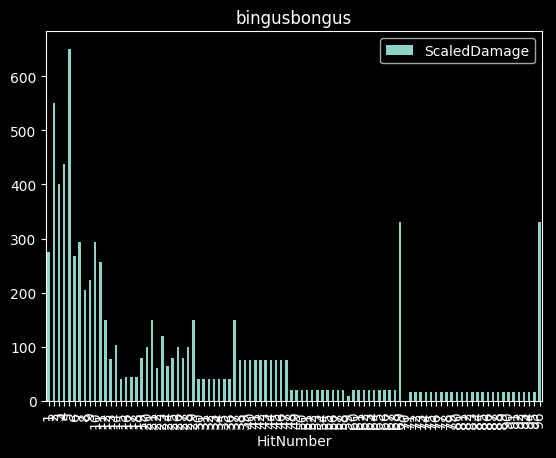

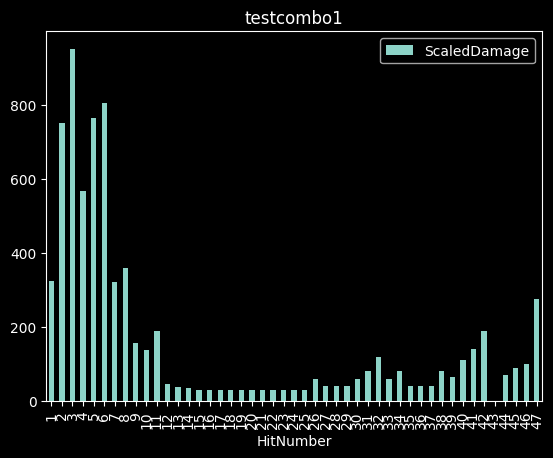

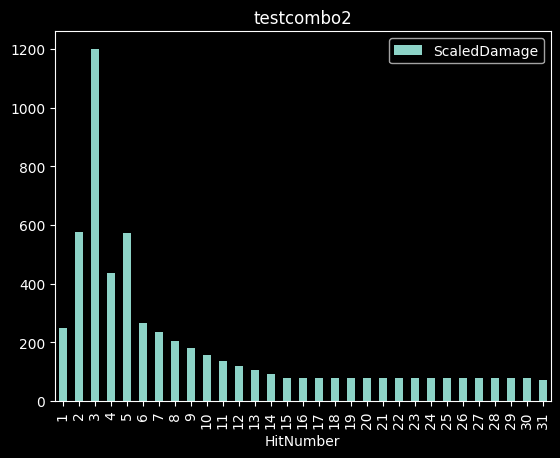

In [4]:

def skombo() -> None:
    """Temp main function.
    TODO(Aeiry): move to a UI."""

    pd.options.display.precision = 2

    for df in [move_name_alias_df, full_framedata_df]:
        remove_whitespace_from_column_names(df)
    csv_list: list[str] = parseCombo.get_csv_list(f"{data_dir}/combo_csvs")

    output = []

    for csv in csv_list:
        csv_filename: str = csv.split("\\")[-1].split(".")[0]
        combo_input_df: pd.DataFrame = pd.read_csv(csv)

        expected_damage: int = parseCombo.get_first_value_from_df(
            combo_input_df, EXPECTED_DAMAGE
        )

        # Set some constants
        character_name: str = parseCombo.get_first_value_from_df(
            combo_input_df, CHARACTER_NAME
        )
        logger.debug(
            f"========== Starting combo for {character_name} from {csv} =========="
        )

        move_column_name: str = MOVE_NAME

        # Create an empty dataframe to hold the combo data
        # Uses the same columns as tempFrameData
        combo_framedata_df: pd.DataFrame = parseCombo.create_df_copy_columns(
            full_framedata_df
        )

        combo_framedata_df = parseCombo.concatenate_dataframes(
            combo_framedata_df,
            parseCombo.split_columns(combo_input_df, move_column_name, " "),
        )

        # Set the character column in the comboDf to the character name
        parseCombo.set_column_value(combo_framedata_df, CHARACTER_NAME, character_name)

        logger.debug(f"Combo dataframe:\n{combo_framedata_df[MOVE_NAME]}\n")

        combo_framedata_df = parseCombo.get_frame_data_for_combo(
            combo_framedata_df, full_framedata_df, move_name_alias_df
        )

        combo_framedata_df: pd.DataFrame = get_combo_damage(combo_framedata_df)

        damage: int = combo_framedata_df[SCALED_DAMAGE].sum()

        combo_framedata_df.plot(
            x=HIT_NUMBER,
            y=[DAMAGE, SCALED_DAMAGE],
            kind="bar",
            title=csv_filename,
        )

        logger.debug(f"Combo dataframe:\n{combo_framedata_df}\n")

        logger.debug(f"Calculated damage: {damage}")
        logger.debug(f"Expected damage: {expected_damage}")
        logger.debug("Difference: " + str(damage - expected_damage))
        logger.debug(
            f"Percentage difference: {round((damage - expected_damage) / expected_damage * 100, 2)}%"
        )

        # Add the combo to the output
        output.append(
            {
                "Character": character_name,
                "Combo": csv_filename,
                "ExpectedDamage": round(expected_damage),
                "CalculatedDamage": round(damage),
                "Difference": damage - round(expected_damage),
                "PercentageDifference": f"{round((damage - expected_damage) / expected_damage * 100)}%",
            }
        )

    # Create a dataframe from the output
    output_df = pd.DataFrame(output)

    logger.info(f"\n{output_df}\n")

    for combo,pct_diff in zip(output_df["Combo"],output_df["PercentageDifference"]):
        if pct_diff != "0%":
            logger.info(f"{combo} has a {pct_diff} difference")
 


def main() -> None:
    """Main function."""

    skombo()


if __name__ == "__main__":

    main()
